# Using Doc2Vec implementation in gensim in order to model protein's structure

This is a tutorial that shows, how you can use gensim in order to build a model on top of the primary structure of proteins. This tutorial was inspired by this [paper](http://arxiv.org/abs/1503.05140).

In order to run this tutorial sucessfully you'll need to also install following packages: `biopython`. This iPython notebook was particularly tested with `biopython==1.66`.

There will be also needed to download the protein structure data from the publicaly available uniprot database. The data comes in the [FASTA](https://en.wikipedia.org/wiki/FASTA_format) format. For purposes of this tutorial I have downloaded only the small sample of the uniprot dataset, particularly only Zebrafish proteins from the SwissProt set that is possible to download [here](http://www.uniprot.org/uniprot/?query=*&fil=proteome%3AUP000000437+AND+organism%3A%22Danio+rerio+%28Zebrafish%29+%28Brachydanio+rerio%29+%5B7955%5D%22) (gzipped data has slightly over 14MB, but you can easily download human proteins or even all the known proteins).

In [1]:
#!/usr/bin python
# -*- coding: utf-8 -*-
# first perform all the necessary imports 
import logging
import os
import sys

import gensim
from gensim.models.doc2vec import TaggedDocument
from Bio import SeqIO

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = 20  # ipython messes up logging, restore root

At the begining, there is needed some reader that would help us to convert primary structure of the protein to corpus of consecutive n-grams of amino acids.

In [2]:
def iterate_uniprot_labeled_ngrams(input_data, n=3):
    """
    Create n-gram sequence generator from the primary structure in
    the FASTA format. 
    :param input_data: str path to the input data
    :param n: int n-gram size
    """
    for seq_record in SeqIO.parse(input_data, "fasta"):
        ngrams = []
        sequence = str(seq_record.seq)
        for it in xrange(n):
            ngrams.extend(
                [sequence[i + it:i + n + it]
                 for i in xrange(0, len(sequence) - 1, n)
                 if len(sequence[i + it:i + n + it]) == n])
        yield TaggedDocument(words=ngrams, tags=[seq_record.id])

Now there can be implemented the main Doc2Vec model training logic.

In [3]:
def train_model(data_path, epochs=15, size=100, window=4, min_count=5, workers=8, ngram_size=3):
    """
    Train the Doc2Vec model on the protein primary structures data in the FASTA format.
    :param data_path: str path to the data
    :param epochs: int
    :param size: int
    :param window: int
    :param min_count: int
    :param workers: int
    :param ngram_size: int
    """
    it = lambda: iterate_uniprot_labeled_ngrams(data_path, n=3)
    model = gensim.models.Doc2Vec(size=size, window=window, min_count=min_count, workers=workers)
    model.build_vocab(it())
    for i in range(epochs):
        model.train(it())
        logging.info("PROGRESS epoch %s from %s", i + 1, epochs)
    return model

Now model can be easily trained as follows (NOTE: this might take a while):

In [4]:
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    protein_doc2vec = gensim.models.Doc2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse.
    protein_doc2vec = train_model("/Users/janzikes/Downloads/uniprot-all.fasta")
    protein_doc2vec.save("protein_model.pkl")

INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 4262857 words (1959500/s), 8110 word types, 10000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #20000, processed 9621896 words (2150485/s), 8483 word types, 20000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #30000, processed 14924008 words (2106753/s), 8562 word types, 30000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #40000, processed 20160525 words (2116482/s), 8618 word types, 40000 tags
INFO:gensim.models.doc2vec:collected 8627 word types and 43441 unique tags from a corpus of 43441 examples and 22085043 words
INFO:gensim.models.word2vec:min_count=5 retains 8284 unique words (drops 343)
INFO:gensim.models.word2vec:min_count leaves 22084440 word corpus (99% of original 22085043)
INFO:gensim.models.word2vec:deleting the raw counts di

## Basic model validation

In the protein_doc2vec we have just created the model based on the primary structure of proteins. Using this model we can for example see, how similar are certain proteins or when we will syntetyse (or generate a new structure using for example [character network](https://github.com/karpathy/char-rnn) trained on FASTA files) a new protein we might try to find the most similar already known proteins.

In [5]:
protein_doc2vec.docvecs.most_similar('sp|Q6NUW5|AN32E_DANRE')

INFO:gensim.models.doc2vec:precomputing L2-norms of doc weight vectors


[('tr|B2GSB4|B2GSB4_DANRE', 0.7664501667022705),
 ('sp|Q7ZUP0|AN32A_DANRE', 0.7652105093002319),
 ('tr|F1QTN7|F1QTN7_DANRE', 0.762782633304596),
 ('tr|E9QB42|E9QB42_DANRE', 0.7046442031860352),
 ('tr|I3ITE4|I3ITE4_DANRE', 0.6973950266838074),
 ('tr|F1Q4N7|F1Q4N7_DANRE', 0.6617193222045898),
 ('tr|E7EZJ7|E7EZJ7_DANRE', 0.5096169710159302),
 ('tr|A0A0R4IAG2|A0A0R4IAG2_DANRE', 0.49199047684669495),
 ('tr|B7ZDB1|B7ZDB1_DANRE', 0.48254919052124023),
 ('tr|Q1LXI0|Q1LXI0_DANRE', 0.47858577966690063)]

## Protein space visualization

In order to visualize whole protein space we migh use the tSNE dimensionality reduction. You'll need to install external `tsne` library, `matplotlib` and `mpld3` in order to run the vizualization part.

First of all we will perform dimensionality reduction to 2 dimensions. This operation again might take a while.

In [7]:
from tsne import bh_sne
from matplotlib import pylab
import numpy as np
import mpld3
%matplotlib inline
mpld3.enable_notebook()

# load all the vectors to np.array
labels = protein_doc2vec.docvecs.doctags.keys()
vectors = []
for key in labels:
    vectors.append(protein_doc2vec.docvecs[key])
matrix = np.vstack(vectors)

# perform the tsne dimensionality reduction
reduced_embeddings = bh_sne(matrix.astype('float64'))

/Users/janzikes/anaconda2/envs/gensim/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/janzikes/anaconda2/envs/gensim/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/janzikes/anaconda2/envs/gensim/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/janzikes/anaconda2/envs/gensim/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: Deprecat

Then we can simply perform the visualization of the proteins space.

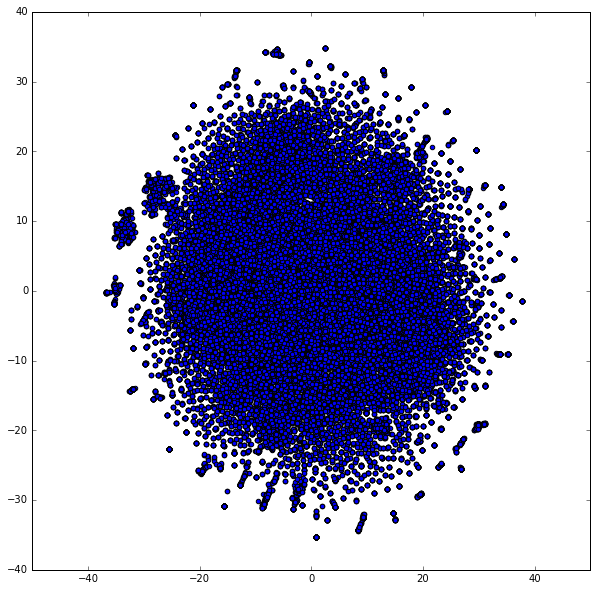

In [8]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    fig, ax = pylab.subplots(figsize=(10, 10))
    scatter = ax.scatter(embeddings[:,0], embeddings[:,1])
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.PointLabelTooltip(fig, tooltip)
    mpld3.plugins.connect(fig, tooltip)

plot(reduced_embeddings, labels)